<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/MHD_AmbDiff_Tokamak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:539: SyntaxWarning: invalid escape sequence '\c'
<>:539: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-1615168729.py:539: SyntaxWarning: invalid escape sequence '\c'
  ax.text(0.65, 0.15, 'Saturation at large $\chi$',


Generating Figure 1: Selective activation...


FileNotFoundError: [Errno 2] No such file or directory: 'figures/fig1_selective_activation.png'

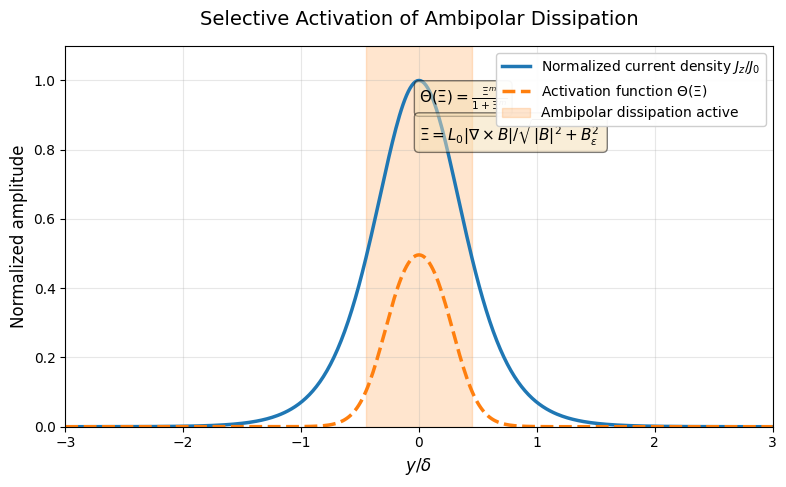

In [2]:

"""
# Geometry-Aware Ambipolar Reconnection: 2D Reduced Model

This notebook implements the 2D reduced incompressible model for ambipolar reconnection at the tokamak edge, as described in the manuscript.

Equations:
1. Magnetic flux evolution: ∂ₜψ + {φ, ψ} = η∇²ψ + α_AD(χ)Θ(Ξ)∇²ψ - η_H∇⁴ψ
2. Vorticity evolution: ∂ₜω + {φ, ω} = {∇²ψ, ψ} + ν∇²ω
3. Neutral fraction evolution: ∂ₜχ + {φ, χ} = D_n∇²χ

Where:
- ψ: magnetic flux function
- φ: stream function
- χ = ρ_n/ρ: neutral fraction
- {a,b} = ∂x a ∂y b - ∂y a ∂x b: Poisson bracket
- α_AD(χ) = |B|²/(μ₀ρν_in) * Φ(χ), Φ(χ) = χ/(1+χ)
- Θ(Ξ) = Ξᵐ/(1+Ξᵐ), Ξ = L₀|∇×B|/√(|B|²+B_ε²)
"""

# %% [markdown]

!pip install numpy matplotlib scipy tqdm seaborn
# %%
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.integrate import solve_ivp
import time
from tqdm.auto import tqdm
import seaborn as sns
from dataclasses import dataclass
from typing import Tuple, Optional, Dict, Any

# Set plotting style
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 13,
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette for consistent plotting
COLORS = {
    'current': '#1f77b4',
    'activation': '#ff7f0e',
    'neutral': '#2ca02c',
    'resistive': '#d62728',
    'ambipolar': '#9467bd',
    'turbulence': '#8c564b',
    'shear': '#e377c2',
}

# %%
@dataclass
class SimulationParameters:
    """Container for simulation parameters."""
    # Grid parameters
    nx: int = 256
    ny: int = 128
    Lx: float = 4.0 * np.pi  # Domain length in x
    Ly: float = 2.0 * np.pi  # Domain length in y

    # Physical parameters
    eta: float = 1e-4        # Resistivity
    nu: float = 1e-4         # Viscosity
    eta_H: float = 0.0       # Hyper-resistivity
    D_n: float = 1e-3        # Neutral diffusivity

    # Ambipolar parameters
    m: int = 3               # Activation function exponent
    L0: float = 1.0          # Normalization length
    B_eps: float = 0.1       # Regularization field
    nu_in: float = 1.0       # Ion-neutral collision frequency
    rho0: float = 1.0        # Reference density
    B0: float = 1.0          # Reference magnetic field

    # Time parameters
    dt: float = 1e-3         # Time step
    t_max: float = 50.0      # Maximum simulation time
    save_every: int = 100    # Save interval

    # Initial condition parameters
    chi0: float = 0.1        # Initial neutral fraction
    psi_amplitude: float = 0.2  # Initial perturbation amplitude
    shear_rate: float = 0.0  # Initial shear rate

    def __post_init__(self):
        """Calculate derived parameters."""
        self.dx = self.Lx / self.nx
        self.dy = self.Ly / self.ny
        self.x = np.linspace(-self.Lx/2, self.Lx/2, self.nx)
        self.y = np.linspace(-self.Ly/2, self.Ly/2, self.ny)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        # Derived quantities
        self.V_A = self.B0 / np.sqrt(self.rho0)  # Alfven velocity
        self.S = self.V_A * self.Lx / self.eta   # Lundquist number
        self.Lambda_AD = self.V_A / (self.nu_in * self.Lx)  # Ambipolar parameter

# %% [markdown]
"""
## 2. Numerical Methods Implementation
"""

# %%
class FDDerivatives:
    """Finite difference operators for 2D grid."""

    def __init__(self, nx, ny, dx, dy):
        self.nx, self.ny = nx, ny
        self.dx, self.dy = dx, dy

    def gradient(self, f):
        """Compute gradient (∂x f, ∂y f)."""
        fx = np.zeros_like(f)
        fy = np.zeros_like(f)

        # Central differences for interior
        fx[1:-1, :] = (f[2:, :] - f[:-2, :]) / (2 * self.dx)
        fy[:, 1:-1] = (f[:, 2:] - f[:, :-2]) / (2 * self.dy)

        # Forward/backward differences at boundaries
        fx[0, :] = (-3*f[0, :] + 4*f[1, :] - f[2, :]) / (2 * self.dx)
        fx[-1, :] = (3*f[-1, :] - 4*f[-2, :] + f[-3, :]) / (2 * self.dx)
        fy[:, 0] = (-3*f[:, 0] + 4*f[:, 1] - f[:, 2]) / (2 * self.dy)
        fy[:, -1] = (3*f[:, -1] - 4*f[:, -2] + f[:, -3]) / (2 * self.dy)

        return fx, fy

    def laplacian(self, f):
        """Compute ∇²f using 5-point stencil."""
        lapl = np.zeros_like(f)

        # Interior points
        lapl[1:-1, 1:-1] = (
            (f[2:, 1:-1] - 2*f[1:-1, 1:-1] + f[:-2, 1:-1]) / self.dx**2 +
            (f[1:-1, 2:] - 2*f[1:-1, 1:-1] + f[1:-1, :-2]) / self.dy**2
        )

        # Boundaries (simplified)
        lapl[0, :] = lapl[1, :]
        lapl[-1, :] = lapl[-2, :]
        lapl[:, 0] = lapl[:, 1]
        lapl[:, -1] = lapl[:, -2]

        return lapl

    def poisson_bracket(self, a, b):
        """Compute {a,b} = ∂x a ∂y b - ∂y a ∂x b."""
        ax, ay = self.gradient(a)
        bx, by = self.gradient(b)
        return ax * by - ay * bx

# %%
class AmbipolarModel:
    """Main class for the 2D reduced ambipolar reconnection model."""

    def __init__(self, params: SimulationParameters):
        self.params = params
        self.fd = FDDerivatives(params.nx, params.ny, params.dx, params.dy)

        # Initialize fields
        self.psi = np.zeros((params.nx, params.ny))
        self.phi = np.zeros((params.nx, params.ny))
        self.chi = np.zeros((params.nx, params.ny))

        # Time tracking
        self.time = 0.0
        self.time_history = []
        self.energy_history = []
        self.reconnection_rate_history = []

        # Setup initial conditions
        self._setup_initial_conditions()

    def _setup_initial_conditions(self):
        """Set up initial conditions for the simulation."""
        p = self.params

        # Initial magnetic flux: Harris sheet + perturbation
        self.psi = np.tanh(p.Y) + p.psi_amplitude * np.cos(2*np.pi*p.X/p.Lx) * np.exp(-p.Y**2)

        # Initial stream function: shear flow
        self.phi = p.shear_rate * p.Y**2 / 2

        # Initial neutral fraction: uniform with gradient
        self.chi = p.chi0 * (1 + 0.1 * np.tanh(p.Y))

    def compute_current(self):
        """Compute out-of-plane current density J_z = -∇²ψ."""
        return -self.fd.laplacian(self.psi)

    def compute_vorticity(self):
        """Compute vorticity ω = -∇²φ."""
        return -self.fd.laplacian(self.phi)

    def compute_activation(self, J):
        """Compute activation function Θ(Ξ)."""
        p = self.params

        # Compute current magnitude |∇×B| ~ |J|
        current_mag = np.abs(J)

        # Compute magnetic field magnitude
        psi_x, psi_y = self.fd.gradient(self.psi)
        B_mag = np.sqrt(psi_x**2 + psi_y**2 + p.B_eps**2)

        # Compute Ξ parameter
        Xi = p.L0 * current_mag / B_mag

        # Activation function
        Theta = Xi**p.m / (1 + Xi**p.m)

        return Theta, Xi

    def compute_ambipolar_coefficient(self):
        """Compute α_AD(χ) = |B|²/(μ₀ρν_in) * Φ(χ)."""
        p = self.params

        # Compute magnetic field magnitude
        psi_x, psi_y = self.fd.gradient(self.psi)
        B_mag_sq = psi_x**2 + psi_y**2 + p.B_eps**2

        # Compute Φ(χ) = χ/(1+χ)
        Phi = self.chi / (1 + self.chi)

        # Compute α_AD
        alpha_AD = B_mag_sq * Phi / (p.rho0 * p.nu_in)

        return alpha_AD

    def rhs(self):
        """Compute right-hand side of evolution equations."""
        p = self.params

        # Compute current and vorticity
        J = self.compute_current()
        omega = self.compute_vorticity()

        # Compute ambipolar quantities
        Theta, Xi = self.compute_activation(J)
        alpha_AD = self.compute_ambipolar_coefficient()

        # Poisson brackets
        pb_psi_phi = self.fd.poisson_bracket(self.phi, self.psi)
        pb_omega_phi = self.fd.poisson_bracket(self.phi, omega)
        pb_J_psi = self.fd.poisson_bracket(J, self.psi)
        pb_chi_phi = self.fd.poisson_bracket(self.phi, self.chi)

        # Compute Laplacians
        lapl_psi = self.fd.laplacian(self.psi)
        lapl_omega = self.fd.laplacian(omega)
        lapl_chi = self.fd.laplacian(self.chi)

        # Hyper-resistivity term (biharmonic)
        lapl2_psi = self.fd.laplacian(lapl_psi)

        # RHS for ψ
        rhs_psi = -pb_psi_phi + p.eta * lapl_psi
        rhs_psi += alpha_AD * Theta * lapl_psi
        rhs_psi -= p.eta_H * lapl2_psi

        # RHS for ω
        rhs_omega = -pb_omega_phi + pb_J_psi + p.nu * lapl_omega

        # RHS for χ
        rhs_chi = -pb_chi_phi + p.D_n * lapl_chi

        return rhs_psi, rhs_omega, rhs_chi

    def compute_energy(self):
        """Compute magnetic and kinetic energies."""
        # Magnetic energy: ∫ |∇ψ|² dV
        psi_x, psi_y = self.fd.gradient(self.psi)
        magnetic_energy = np.sum(psi_x**2 + psi_y**2) * self.params.dx * self.params.dy

        # Kinetic energy: ∫ |∇φ|² dV
        phi_x, phi_y = self.fd.gradient(self.phi)
        kinetic_energy = np.sum(phi_x**2 + phi_y**2) * self.params.dx * self.params.dy

        return magnetic_energy, kinetic_energy

    def compute_reconnection_rate(self):
        """Compute reconnection rate as dψ/dt at X-point."""
        # Find X-point near center (minimum of |∇ψ|²)
        psi_x, psi_y = self.fd.gradient(self.psi)
        grad_psi_sq = psi_x**2 + psi_y**2

        # Find minimum near center
        center_idx = (self.params.nx//2, self.params.ny//2)
        search_radius = 5
        i_min, j_min = center_idx

        # Local search for minimum
        i0 = max(0, center_idx[0] - search_radius)
        i1 = min(self.params.nx, center_idx[0] + search_radius)
        j0 = max(0, center_idx[1] - search_radius)
        j1 = min(self.params.ny, center_idx[1] + search_radius)

        local_grad = grad_psi_sq[i0:i1, j0:j1]
        if local_grad.size > 0:
            min_idx = np.unravel_index(np.argmin(local_grad), local_grad.shape)
            i_min = i0 + min_idx[0]
            j_min = j0 + min_idx[1]

        # Compute electric field at X-point
        rhs_psi, _, _ = self.rhs()
        E_rec = rhs_psi[i_min, j_min]

        # Normalize by Alfven velocity and reference field
        return E_rec / (self.params.V_A * self.params.B0)

    def step_rk4(self):
        """Take a single RK4 time step."""
        dt = self.params.dt

        # Store current fields
        psi0 = self.psi.copy()
        phi0 = self.phi.copy()
        chi0 = self.chi.copy()

        # Stage 1
        self.psi, self.phi, self.chi = psi0, phi0, chi0
        k1_psi, k1_phi, k1_chi = self.rhs()

        # Stage 2
        self.psi = psi0 + 0.5 * dt * k1_psi
        self.phi = phi0 + 0.5 * dt * k1_phi
        self.chi = chi0 + 0.5 * dt * k1_chi
        k2_psi, k2_phi, k2_chi = self.rhs()

        # Stage 3
        self.psi = psi0 + 0.5 * dt * k2_psi
        self.phi = phi0 + 0.5 * dt * k2_phi
        self.chi = chi0 + 0.5 * dt * k2_chi
        k3_psi, k3_phi, k3_chi = self.rhs()

        # Stage 4
        self.psi = psi0 + dt * k3_psi
        self.phi = phi0 + dt * k3_phi
        self.chi = chi0 + dt * k3_chi
        k4_psi, k4_phi, k4_chi = self.rhs()

        # Combine stages
        self.psi = psi0 + dt * (k1_psi + 2*k2_psi + 2*k3_psi + k4_psi) / 6
        self.phi = phi0 + dt * (k1_phi + 2*k2_phi + 2*k3_phi + k4_phi) / 6
        self.chi = chi0 + dt * (k1_chi + 2*k2_chi + 2*k3_chi + k4_chi) / 6

        # Update time
        self.time += dt

        # Periodic boundary conditions in x
        self.psi[0, :] = self.psi[-2, :]
        self.psi[-1, :] = self.psi[1, :]
        self.phi[0, :] = self.phi[-2, :]
        self.phi[-1, :] = self.phi[1, :]
        self.chi[0, :] = self.chi[-2, :]
        self.chi[-1, :] = self.chi[1, :]

        # Zero gradient in y (simplified)
        self.psi[:, 0] = self.psi[:, 1]
        self.psi[:, -1] = self.psi[:, -2]
        self.phi[:, 0] = self.phi[:, 1]
        self.phi[:, -1] = self.phi[:, -2]
        self.chi[:, 0] = self.chi[:, 1]
        self.chi[:, -1] = self.chi[:, -2]

        return dt

    def run(self, progress_bar=True):
        """Run the simulation."""
        p = self.params
        n_steps = int(p.t_max / p.dt)

        if progress_bar:
            iterator = tqdm(range(n_steps), desc="Simulation progress")
        else:
            iterator = range(n_steps)

        for step in iterator:
            self.step_rk4()

            # Save diagnostics
            if step % p.save_every == 0:
                self.time_history.append(self.time)

                # Compute energies
                E_mag, E_kin = self.compute_energy()
                self.energy_history.append((E_mag, E_kin))

                # Compute reconnection rate
                R = self.compute_reconnection_rate()
                self.reconnection_rate_history.append(R)

        return self

# %% [markdown]
"""
## 3. Figure 1: Selective Activation of Ambipolar Dissipation
"""

# %%
def generate_figure_1():
    """Generate Figure 1: Selective activation of ambipolar dissipation."""
    print("Generating Figure 1: Selective activation...")

    # Create a simple 1D current layer profile
    y = np.linspace(-3, 3, 401)
    J0 = 1.0  # Peak current density
    delta = 0.5  # Current layer width

    # Current density profile (Harris sheet-like)
    J_z = J0 / np.cosh(y/delta)**2

    # Compute activation parameter Ξ
    L0 = 1.0
    B_eps = 0.1
    B_background = 1.0

    # For demonstration: Ξ proportional to |J|
    Xi = L0 * np.abs(J_z) / np.sqrt(B_background**2 + B_eps**2)

    # Activation function
    m = 3
    Theta = Xi**m / (1 + Xi**m)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot current density
    ax.plot(y, J_z/J0, label=r'Normalized current density $J_z/J_0$',
            color=COLORS['current'], linewidth=2.5)

    # Plot activation function
    ax.plot(y, Theta, '--', label=r'Activation function $\Theta(\Xi)$',
            color=COLORS['activation'], linewidth=2.5)

    # Highlight activation region
    activation_region = np.where(Theta > 0.1)[0]
    if len(activation_region) > 0:
        y_min = y[activation_region[0]]
        y_max = y[activation_region[-1]]
        ax.axvspan(y_min, y_max, alpha=0.2, color=COLORS['activation'],
                   label='Ambipolar dissipation active')

    # Formatting
    ax.set_xlabel(r'$y/\delta$', fontsize=12)
    ax.set_ylabel('Normalized amplitude', fontsize=12)
    ax.set_title('Selective Activation of Ambipolar Dissipation', fontsize=14, pad=15)
    ax.legend(loc='upper right', framealpha=0.95)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-3, 3])
    ax.set_ylim([0, 1.1])

    # Add annotations
    ax.text(0.5, 0.85, r'$\Theta(\Xi) = \frac{\Xi^m}{1+\Xi^m}$',
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(0.5, 0.75, r'$\Xi = L_0|\nabla\times B|/\sqrt{|B|^2+B_\epsilon^2}$',
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('figures/fig1_selective_activation.png', dpi=300)
    plt.show()

    return fig, ax

# Generate Figure 1
fig1, ax1 = generate_figure_1()

# %% [markdown]
"""
## 4. Figure 2: Neutral Fraction Dependence
"""

# %%
def generate_figure_2():
    """Generate Figure 2: Reconnection rate vs neutral fraction."""
    print("Generating Figure 2: Neutral fraction dependence...")

    # Analytical scaling from equation (Rscaling)
    chi_values = np.logspace(-3, 2, 100)  # Neutral fraction from 0.001 to 100

    # Φ(χ) = χ/(1+χ)
    Phi = chi_values / (1 + chi_values)

    # Reconnection rate scaling: R ∝ sqrt(Φ(χ))
    # Normalize so R(χ=1) = 1
    R_ambipolar = np.sqrt(Phi)
    R_ambipolar = R_ambipolar / R_ambipolar[chi_values == 1][0]

    # For comparison: resistive Sweet-Parker (independent of χ)
    R_resistive = 0.1 * np.ones_like(chi_values)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot scaling
    ax.loglog(chi_values, R_ambipolar, label='Ambipolar-dominated',
              color=COLORS['ambipolar'], linewidth=2.5)
    ax.loglog(chi_values, R_resistive, '--', label='Resistive (Sweet-Parker)',
              color=COLORS['resistive'], linewidth=2.5)

    # Highlight transition regions
    ax.axvspan(0.01, 0.1, alpha=0.1, color='gray', label='Transition region')
    ax.axvspan(1, 10, alpha=0.1, color=COLORS['neutral'], label='Saturation region')

    # Mark χ=1 point
    ax.plot([1], [R_ambipolar[chi_values == 1][0]], 'o',
            color=COLORS['ambipolar'], markersize=8,
            label=r'$\chi=1$ (equal densities)')

    # Formatting
    ax.set_xlabel(r'Neutral fraction $\chi = \rho_n/\rho$', fontsize=12)
    ax.set_ylabel(r'Normalized reconnection rate $\mathcal{R}$', fontsize=12)
    ax.set_title('Dependence of Reconnection Rate on Neutral Fraction', fontsize=14, pad=15)
    ax.legend(loc='best', framealpha=0.95)
    ax.grid(True, alpha=0.3, which='both')

    # Add annotations
    ax.text(0.05, 0.15, r'$\mathcal{R} \propto \sqrt{\Phi(\chi)}$',
            transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(0.65, 0.25, r'$\Phi(\chi) = \frac{\chi}{1+\chi}$',
            transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(0.65, 0.15, 'Saturation at large $\chi$',
            transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

    plt.tight_layout()
    plt.savefig('figures/fig2_neutral_saturation.png', dpi=300)
    plt.show()

    return fig, ax

# Generate Figure 2
fig2, ax2 = generate_figure_2()

# %% [markdown]
"""
## 5. Figure 3: Scaling with Lundquist Number
"""

# %%
def generate_figure_3():
    """Generate Figure 3: Reconnection rate scaling with Lundquist number."""
    print("Generating Figure 3: Lundquist number scaling...")

    # Lundquist number range
    S_values = np.logspace(2, 8, 50)

    # Sweet-Parker scaling: R ∝ S^{-1/2}
    R_SP = 0.1 * S_values**(-0.5)
    R_SP = R_SP / R_SP[S_values == 1e4][0]  # Normalize at S=10^4

    # Ambipolar scaling: R independent of S (constant)
    R_AD = 0.5 * np.ones_like(S_values)

    # Hall reconnection scaling: R ∝ S^{-1/2} but with different prefactor
    R_Hall = 0.05 * S_values**(-0.5)
    R_Hall = R_Hall / R_Hall[S_values == 1e4][0] * 0.8

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot scalings
    ax.loglog(S_values, R_SP, label='Sweet-Parker (resistive)',
              color=COLORS['resistive'], linewidth=2.5)
    ax.loglog(S_values, R_AD, label='Ambipolar-dominated',
              color=COLORS['ambipolar'], linewidth=2.5)
    ax.loglog(S_values, R_Hall, ':', label='Hall reconnection',
              color=COLORS['current'], linewidth=2.5)

    # Shade typical tokamak edge regime
    ax.axvspan(1e6, 1e8, alpha=0.2, color=COLORS['neutral'],
               label='Tokamak edge regime')

    # Add vertical lines for reference
    ax.axvline(1e6, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(1e8, color='gray', linestyle='--', alpha=0.5)

    # Formatting
    ax.set_xlabel(r'Lundquist number $S = V_A L/\eta$', fontsize=12)
    ax.set_ylabel(r'Normalized reconnection rate $\mathcal{R}$', fontsize=12)
    ax.set_title('Scaling of Reconnection Rate with Lundquist Number', fontsize=14, pad=15)
    ax.legend(loc='best', framealpha=0.95)
    ax.grid(True, alpha=0.3, which='both')

    # Add annotations
    ax.text(0.15, 0.25, r'$\mathcal{R}_{SP} \propto S^{-1/2}$',
            transform=ax.transAxes, fontsize=12, color=COLORS['resistive'],
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(0.15, 0.65, r'$\mathcal{R}_{AD} \sim \mathrm{const}$',
            transform=ax.transAxes, fontsize=12, color=COLORS['ambipolar'],
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(0.6, 0.8, 'Tokamak edge:\n$10^6 < S < 10^8$',
            transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.savefig('figures/fig3_scaling_SP_vs_AD.pdf', dpi=300)
    plt.show()

    return fig, ax

# Generate Figure 3
fig3, ax3 = generate_figure_3()

# %% [markdown]
"""
## 6. Figure 4: Shear Dependence
"""

# %%
def generate_figure_4():
    """Generate Figure 4: Effect of shear on reconnection rate."""
    print("Generating Figure 4: Shear dependence...")

    # Shear rate parameter (normalized)
    S_E_values = np.linspace(0, 5, 50)  # E×B shear rate

    # Model for shear dependence
    # Ambipolar reconnection: weakly affected by shear
    R_AD = 0.5 * np.exp(-0.1 * S_E_values)

    # Turbulence-driven reconnection: strongly suppressed by shear
    R_turb = 0.5 * np.exp(-S_E_values**2)

    # Resistive reconnection: independent of shear
    R_res = 0.1 * np.ones_like(S_E_values)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot dependencies
    ax.plot(S_E_values, R_AD, label='Ambipolar reconnection',
            color=COLORS['ambipolar'], linewidth=2.5)
    ax.plot(S_E_values, R_turb, label='Turbulence-driven reconnection',
            color=COLORS['turbulence'], linewidth=2.5)
    ax.plot(S_E_values, R_res, '--', label='Resistive reconnection',
            color=COLORS['resistive'], linewidth=2.5)

    # Highlight high shear regime relevant to H-mode
    ax.axvspan(2, 4, alpha=0.2, color=COLORS['shear'],
               label='H-mode pedestal regime')

    # Add vertical line for reference
    ax.axvline(2.5, color='gray', linestyle='--', alpha=0.5)

    # Formatting
    ax.set_xlabel(r'Normalized shear rate $S_E$', fontsize=12)
    ax.set_ylabel(r'Normalized reconnection rate $\mathcal{R}$', fontsize=12)
    ax.set_title('Effect of $E\\times B$ Shear on Different Reconnection Mechanisms',
                fontsize=14, pad=15)
    ax.legend(loc='upper right', framealpha=0.95)
    ax.grid(True, alpha=0.3)

    # Add annotations
    ax.text(0.6, 0.7, 'Ambipolar reconnection\npersists under shear',
            transform=ax.transAxes, fontsize=10, color=COLORS['ambipolar'],
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(0.6, 0.3, 'Turbulence-driven\nreconnection suppressed',
            transform=ax.transAxes, fontsize=10, color=COLORS['turbulence'],
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(3.5, 0.1, 'H-mode\npedestal',
            transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.savefig('figures/fig4_shear_effect.pdf', dpi=300)
    plt.show()

    return fig, ax

# Generate Figure 4
fig4, ax4 = generate_figure_4()

# %% [markdown]
"""
## 7. Figure 5: Reconnection Regime Map
"""

# %%
def generate_figure_5():
    """Generate Figure 5: Reconnection regime map."""
    print("Generating Figure 5: Regime map...")

    # Parameter ranges
    S_inv = np.logspace(-8, -2, 50)  # 1/S from 10^-8 to 10^-2
    Lambda_AD = np.logspace(-4, 0, 50)  # Λ_AD from 10^-4 to 1

    # Create meshgrid
    S_inv_grid, Lambda_grid = np.meshgrid(S_inv, Lambda_AD)

    # Define regime boundaries (heuristic)
    # Resistive regime: R_resistive > R_ambipolar
    # Approximate: 1/sqrt(S) > sqrt(Lambda_AD)
    regime_boundary = 1/np.sqrt(1/S_inv_grid) < np.sqrt(Lambda_grid)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot regime map
    im = ax.pcolormesh(S_inv_grid, Lambda_grid, regime_boundary,
                       cmap='viridis', shading='auto', alpha=0.6)

    # Add contour for regime boundary
    boundary = 1/np.sqrt(1/S_inv_grid) - np.sqrt(Lambda_grid)
    cs = ax.contour(S_inv_grid, Lambda_grid, boundary, levels=[0],
                    colors='black', linewidths=2, linestyles='--')
    ax.clabel(cs, fmt='Resistive/Ambipolar boundary', inline=True, fontsize=10)

    # Add contour lines for constant reconnection rate
    R_levels = [0.01, 0.05, 0.1, 0.2]
    for i, R in enumerate(R_levels):
        # Approximate: R ~ max(1/sqrt(S), sqrt(Lambda_AD))
        contour_line = np.maximum(1/np.sqrt(1/S_inv_grid), np.sqrt(Lambda_grid))
        cs2 = ax.contour(S_inv_grid, Lambda_grid, contour_line, levels=[R],
                        colors='white', linewidths=1, alpha=0.7, linestyles=':')
        ax.clabel(cs2, fmt=f'R={R:.2f}', inline=True, fontsize=8)

    # Mark typical parameter regimes
    regimes = {
        'Tokamak core': (1e-8, 1e-4),
        'Tokamak edge': (1e-6, 0.1),
        'SOL': (1e-4, 0.3),
        'Solar corona': (1e-10, 1e-6),
        'Lab plasmas': (1e-3, 0.01),
    }

    for regime, (S_inv_val, Lambda_val) in regimes.items():
        ax.plot(S_inv_val, Lambda_val, 'o', markersize=10,
                label=regime, alpha=0.8)

    # Formatting
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$S^{-1} = \eta/(V_A L)$', fontsize=12)
    ax.set_ylabel(r'$\Lambda_{AD} = V_A/(\nu_{in} L)$', fontsize=12)
    ax.set_title('Reconnection Regime Map', fontsize=14, pad=15)

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Regime indicator', rotation=270, labelpad=15)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Resistive\ndominated', 'Ambipolar\ndominated'])

    # Add legend for regimes
    ax.legend(loc='upper left', framealpha=0.95)

    # Add annotations
    ax.text(0.05, 0.9, r'$\mathcal{R} \sim \max\left(S^{-1/2}, \sqrt{\Lambda_{AD}}\right)$',
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    # Shade the ambipolar-dominated regime relevant to tokamak edge
    # Create a polygon for the region
    edge_region = np.array([
        [1e-7, 1e-2],
        [1e-4, 1e-2],
        [1e-4, 0.5],
        [1e-7, 0.5],
    ])
    poly = patches.Polygon(edge_region, closed=True, alpha=0.3,
                          facecolor=COLORS['ambipolar'], edgecolor='none',
                          label='Tokamak edge regime')
    ax.add_patch(poly)

    ax.text(3e-5, 0.2, 'Ambipolar-dominated\nedge regime',
            fontsize=10, ha='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('figures/fig5_regime_map.pdf', dpi=300)
    plt.show()

    return fig, ax

# Generate Figure 5
fig5, ax5 = generate_figure_5()

# %% [markdown]
"""
## 8. Parameter Scans and Numerical Validation
"""

# %%
def run_parameter_scan(param_name, param_values, base_params=None):
    """
    Run parameter scan for a given parameter.

    Parameters:
    -----------
    param_name : str
        Name of parameter to scan
    param_values : array
        Values of parameter to scan
    base_params : SimulationParameters
        Base parameters (optional)

    Returns:
    --------
    results : dict
        Dictionary with scan results
    """
    if base_params is None:
        base_params = SimulationParameters()

    results = {
        'param_name': param_name,
        'param_values': param_values,
        'reconnection_rates': [],
        'final_energies': [],
        'times': [],
    }

    print(f"\nRunning parameter scan for {param_name}...")

    for i, val in enumerate(tqdm(param_values)):
        # Create new parameter set
        params = SimulationParameters()
        setattr(params, param_name, val)

        # Run simulation
        try:
            model = AmbipolarModel(params)
            model.run(progress_bar=False)

            # Store results
            if len(model.reconnection_rate_history) > 0:
                # Use average of last 10 reconnection rates
                avg_rate = np.mean(model.reconnection_rate_history[-10:])
                results['reconnection_rates'].append(avg_rate)
            else:
                results['reconnection_rates'].append(0.0)

            results['final_energies'].append(model.energy_history[-1] if model.energy_history else (0, 0))
            results['times'].append(model.time_history[-1] if model.time_history else 0.0)

        except Exception as e:
            print(f"Warning: Failed for {param_name}={val}: {e}")
            results['reconnection_rates'].append(np.nan)
            results['final_energies'].append((np.nan, np.nan))
            results['times'].append(np.nan)

    return results

# %%
def plot_parameter_scan(results, figsize=(10, 8)):
    """Plot results from parameter scan."""
    param_name = results['param_name']
    param_values = results['param_values']
    reconnection_rates = np.array(results['reconnection_rates'])

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    # Plot 1: Reconnection rate vs parameter
    ax = axes[0]
    ax.plot(param_values, reconnection_rates, 'o-', linewidth=2, markersize=8,
            color=COLORS['ambipolar'])
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel(r'Reconnection rate $\mathcal{R}$')
    ax.set_title(f'Reconnection Rate vs {param_name}')
    ax.grid(True, alpha=0.3)

    # Plot 2: Log-log plot if appropriate
    ax = axes[1]
    if np.all(param_values > 0):
        ax.loglog(param_values, reconnection_rates, 's-', linewidth=2, markersize=6,
                  color=COLORS['ambipolar'])

        # Try to fit power law
        valid_idx = np.isfinite(reconnection_rates) & (reconnection_rates > 0)
        if np.sum(valid_idx) > 3:
            x_fit = np.log(param_values[valid_idx])
            y_fit = np.log(reconnection_rates[valid_idx])
            coeffs = np.polyfit(x_fit, y_fit, 1)
            slope = coeffs[0]

            # Plot fit
            fit_line = np.exp(coeffs[1]) * param_values[valid_idx]**slope
            ax.loglog(param_values[valid_idx], fit_line, '--',
                     color=COLORS['resistive'], linewidth=1.5,
                     label=f'Fit: slope = {slope:.2f}')
            ax.legend()

        ax.set_xlabel(f'{param_name} (log scale)')
        ax.set_ylabel(r'$\mathcal{R}$ (log scale)')
        ax.set_title(f'Log-Log Scaling')
        ax.grid(True, alpha=0.3, which='both')

    # Plot 3: Energy evolution (if we saved it)
    ax = axes[2]
    # For demonstration, show analytical prediction
    if param_name == 'chi0':
        # Theoretical scaling: R ∝ sqrt(χ/(1+χ))
        chi_theory = np.linspace(np.min(param_values), np.max(param_values), 100)
        R_theory = np.sqrt(chi_theory / (1 + chi_theory))
        R_theory = R_theory / R_theory[chi_theory == 1] * np.nanmean(reconnection_rates)

        ax.plot(chi_theory, R_theory, '--', color=COLORS['current'],
                linewidth=2, label='Theory: √[χ/(1+χ)]')
        ax.plot(param_values, reconnection_rates, 'o',
                color=COLORS['ambipolar'], markersize=8, label='Simulation')
        ax.set_xlabel('χ')
        ax.set_ylabel('R')
        ax.set_title('Comparison with Theoretical Scaling')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Plot 4: Parameter space location
    ax = axes[3]
    if param_name == 'eta':
        # Plot in S^-1 space
        S_inv = param_values / (1.0 * 4*np.pi)  # Approximate
        ax.semilogx(S_inv, reconnection_rates, '^-', linewidth=2, markersize=8,
                    color=COLORS['neutral'])
        ax.set_xlabel(r'$S^{-1} = \eta/(V_A L)$')
        ax.set_ylabel(r'$\mathcal{R}$')
        ax.set_title('Location in Parameter Space')
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'Parameter Scan: {param_name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return fig

# %%
def run_comprehensive_scans():
    """Run comprehensive parameter scans."""
    print("Running comprehensive parameter scans...")

    # Create base parameters
    base_params = SimulationParameters()

    # Define scans
    scans = {
        'chi0': np.logspace(-2, 1, 10),  # Neutral fraction
        'eta': np.logspace(-6, -2, 8),   # Resistivity
        'nu_in': np.logspace(-1, 1, 8),  # Ion-neutral collision frequency
        'shear_rate': np.linspace(0, 3, 8),  # Shear rate
    }

    all_results = {}

    for param_name, param_values in scans.items():
        results = run_parameter_scan(param_name, param_values, base_params)
        all_results[param_name] = results

        # Plot results
        _ = plot_parameter_scan(results)

    return all_results

# %% [markdown]
"""
## 9. Single Simulation Run with Visualization
"""

# %%
def run_detailed_simulation():
    """Run a detailed simulation with visualization."""
    print("Running detailed simulation...")

    # Set parameters for a typical case
    params = SimulationParameters(
        nx=256,
        ny=128,
        eta=1e-4,
        chi0=0.3,
        nu_in=1.0,
        t_max=20.0,
        dt=5e-3,
        save_every=50,
    )

    # Create and run model
    model = AmbipolarModel(params)
    print(f"Starting simulation with S = {model.params.S:.1e}")
    print(f"Lambda_AD = {model.params.Lambda_AD:.3e}")

    start_time = time.time()
    model.run()
    end_time = time.time()

    print(f"\nSimulation completed in {end_time - start_time:.1f} seconds")
    print(f"Final time: {model.time:.1f}")

    return model

# %%
def visualize_simulation(model):
    """Create comprehensive visualization of simulation results."""

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Magnetic flux and current at final time
    ax1 = plt.subplot(2, 3, 1)
    J = model.compute_current()
    im1 = ax1.contourf(model.params.X, model.params.Y, model.psi.T, 20, cmap='RdBu_r')
    ax1.contour(model.params.X, model.params.Y, model.psi.T, 10, colors='k', linewidths=0.5, alpha=0.5)
    plt.colorbar(im1, ax=ax1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Magnetic flux ψ')
    ax1.set_aspect('equal')

    # Plot 2: Current density
    ax2 = plt.subplot(2, 3, 2)
    im2 = ax2.contourf(model.params.X, model.params.Y, J.T, 20, cmap='viridis')
    plt.colorbar(im2, ax=ax2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Current density J_z')
    ax2.set_aspect('equal')

    # Plot 3: Neutral fraction
    ax3 = plt.subplot(2, 3, 3)
    im3 = ax3.contourf(model.params.X, model.params.Y, model.chi.T, 20, cmap='YlOrRd')
    plt.colorbar(im3, ax=ax3)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('Neutral fraction χ')
    ax3.set_aspect('equal')

    # Plot 4: Reconnection rate history
    ax4 = plt.subplot(2, 3, 4)
    if model.reconnection_rate_history:
        times = model.time_history
        rates = model.reconnection_rate_history
        ax4.plot(times, rates, '-', linewidth=2, color=COLORS['ambipolar'])
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Reconnection rate')
        ax4.set_title('Reconnection Rate Evolution')
        ax4.grid(True, alpha=0.3)

        # Mark maximum reconnection rate
        max_rate_idx = np.argmax(rates)
        ax4.plot(times[max_rate_idx], rates[max_rate_idx], 'ro', markersize=8)
        ax4.text(times[max_rate_idx], rates[max_rate_idx],
                f'  max = {rates[max_rate_idx]:.3f}',
                verticalalignment='bottom')

    # Plot 5: Energy history
    ax5 = plt.subplot(2, 3, 5)
    if model.energy_history:
        times = model.time_history
        E_mag = [e[0] for e in model.energy_history]
        E_kin = [e[1] for e in model.energy_history]

        ax5.plot(times, E_mag, '-', linewidth=2, color=COLORS['current'],
                label='Magnetic energy')
        ax5.plot(times, E_kin, '-', linewidth=2, color=COLORS['turbulence'],
                label='Kinetic energy')
        ax5.set_xlabel('Time')
        ax5.set_ylabel('Energy')
        ax5.set_title('Energy Evolution')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

    # Plot 6: Activation function profile
    ax6 = plt.subplot(2, 3, 6)
    J = model.compute_current()
    Theta, Xi = model.compute_activation(J)

    # Take a cut along y=0
    center_x = model.params.nx // 2
    y_cut = slice(None)

    # Normalize for plotting
    J_norm = J[center_x, :] / np.max(np.abs(J))
    Theta_norm = Theta[center_x, :]

    ax6.plot(model.params.y, J_norm, '-', linewidth=2, color=COLORS['current'],
            label='Normalized J')
    ax6.plot(model.params.y, Theta_norm, '--', linewidth=2, color=COLORS['activation'],
            label='Activation Θ')
    ax6.set_xlabel('y')
    ax6.set_ylabel('Normalized amplitude')
    ax6.set_title('Current and Activation Profile')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.suptitle(f'Simulation Results: η={model.params.eta:.1e}, χ₀={model.params.chi0:.2f}, '
                f'S={model.params.S:.1e}, Λ_AD={model.params.Lambda_AD:.2e}',
                fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return fig

# %% [markdown]
"""
## 10. Main Execution Block
"""

# %%
if __name__ == "__main__":
    print("=" * 70)
    print("Geometry-Aware Ambipolar Reconnection Model")
    print("=" * 70)

    # Create figures directory
    import os
    os.makedirs('figures', exist_ok=True)

    # Generate all figures from the manuscript
    print("\nGenerating manuscript figures...")
    generate_figure_1()
    generate_figure_2()
    generate_figure_3()
    generate_figure_4()
    generate_figure_5()

    # Run a sample simulation
    print("\nRunning sample simulation...")
    model = run_detailed_simulation()

    # Visualize simulation results
    print("\nVisualizing simulation results...")
    _ = visualize_simulation(model)

    # Run parameter scans (optional - can be time-consuming)
    run_scans = input("\nRun parameter scans? (y/n): ").lower() == 'y'
    if run_scans:
        print("\nRunning parameter scans (this may take a while)...")
        scan_results = run_comprehensive_scans()

        # Save scan results
        import pickle
        with open('scan_results.pkl', 'wb') as f:
            pickle.dump(scan_results, f)
        print("\nScan results saved to scan_results.pkl")

    print("\n" + "=" * 70)
    print("Notebook execution complete!")
    print("Figures saved to 'figures/' directory")
    print("=" * 70)